In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch
from pathlib import Path
import numpy as np
import numba as nb
import pywt
import wfdb
from tqdm import tqdm
from dataclasses import dataclass
from numpy.random import choice, shuffle
from matplotlib import pyplot as plt
from typing import Callable, List
from timeit import default_timer as timer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import one_hot
import torch.nn as nn
from CommonFunctions import *
%matplotlib inline

In [3]:
svdb_dir = Path('./svdb_dir')
svdb_files = [file.stem for file in svdb_dir.glob('*.dat')]
print(svdb_files)

['800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894']


In [4]:
time_window = 40
all_beats = []
all_annotations = []
for in_file in svdb_files:
    annotations = wfdb.rdann(str(os.path.join(svdb_dir, in_file)), 'atr')
    ann_symbols = annotations.symbol[5:-5]
    ann_locations = annotations.sample[5:-5]
    signal, fields = wfdb.rdsamp(str(os.path.join(svdb_dir, in_file)), channels=[0])
    signal = signal.flatten()
    for symbol, location in zip(ann_symbols, ann_locations):
        if symbol in ['N', 'S', 'V']:
            all_beats.append(signal[location - time_window: location + time_window])
            all_annotations.append(symbol)
all_beats = np.vstack(all_beats)
all_annotations = np.array(all_annotations)
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

(183707, 80) (183707,)
no of N beats: 161653
no of S beats: 12146
no of V beats: 9908


In [5]:
def randomly_pick_indexes(labels: np.array, quantity: int, proportions: dict[str, float]):
    group_labels = list(proportions.keys())
    group_proportions = [round(quantity * p) for p in proportions.values()]
    picks = []
    for label, proportion in zip(group_labels, group_proportions):
        group = np.where(labels == label)[0]
        picks.append(choice(group, size=proportion, replace=False))
    picks = np.hstack(picks)
    shuffle(picks)
    return picks

def plot_random_beats(beats, beat_annotations, size, proportions, title=None, file=None):
    colors = {'N': 'lime', 'S': 'blue', 'V': 'red'}
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(*size, layout='constrained', figsize=(12, 12))
        fontsize = figure.axes[0].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        fontsize = fontsize.width * 0.15 * figure.dpi
        random_ann_labels = randomly_pick_indexes(beat_annotations, size[0] * size[1], proportions)
        for ax, random_index in zip(figure.axes, random_ann_labels):
            ax.plot(beats[random_index], color=colors[beat_annotations[random_index]])
            ax.text(x=0.02, y=0.98, s=f'{beat_annotations[random_index]}',
                    transform=ax.transAxes, fontweight='bold', fontsize=fontsize)
            ax.axis(False)
            enhance_plot(figure, ax, glow=True, alpha_gradient=0.8, dpi=150)
        figure.suptitle(title, )
    if file is None:
        figure.savefig(f'images/random_beat_images{"x".join([str(coord) for coord in size])}.png')
    else:
        figure.savefig(f'images/{file}.png')

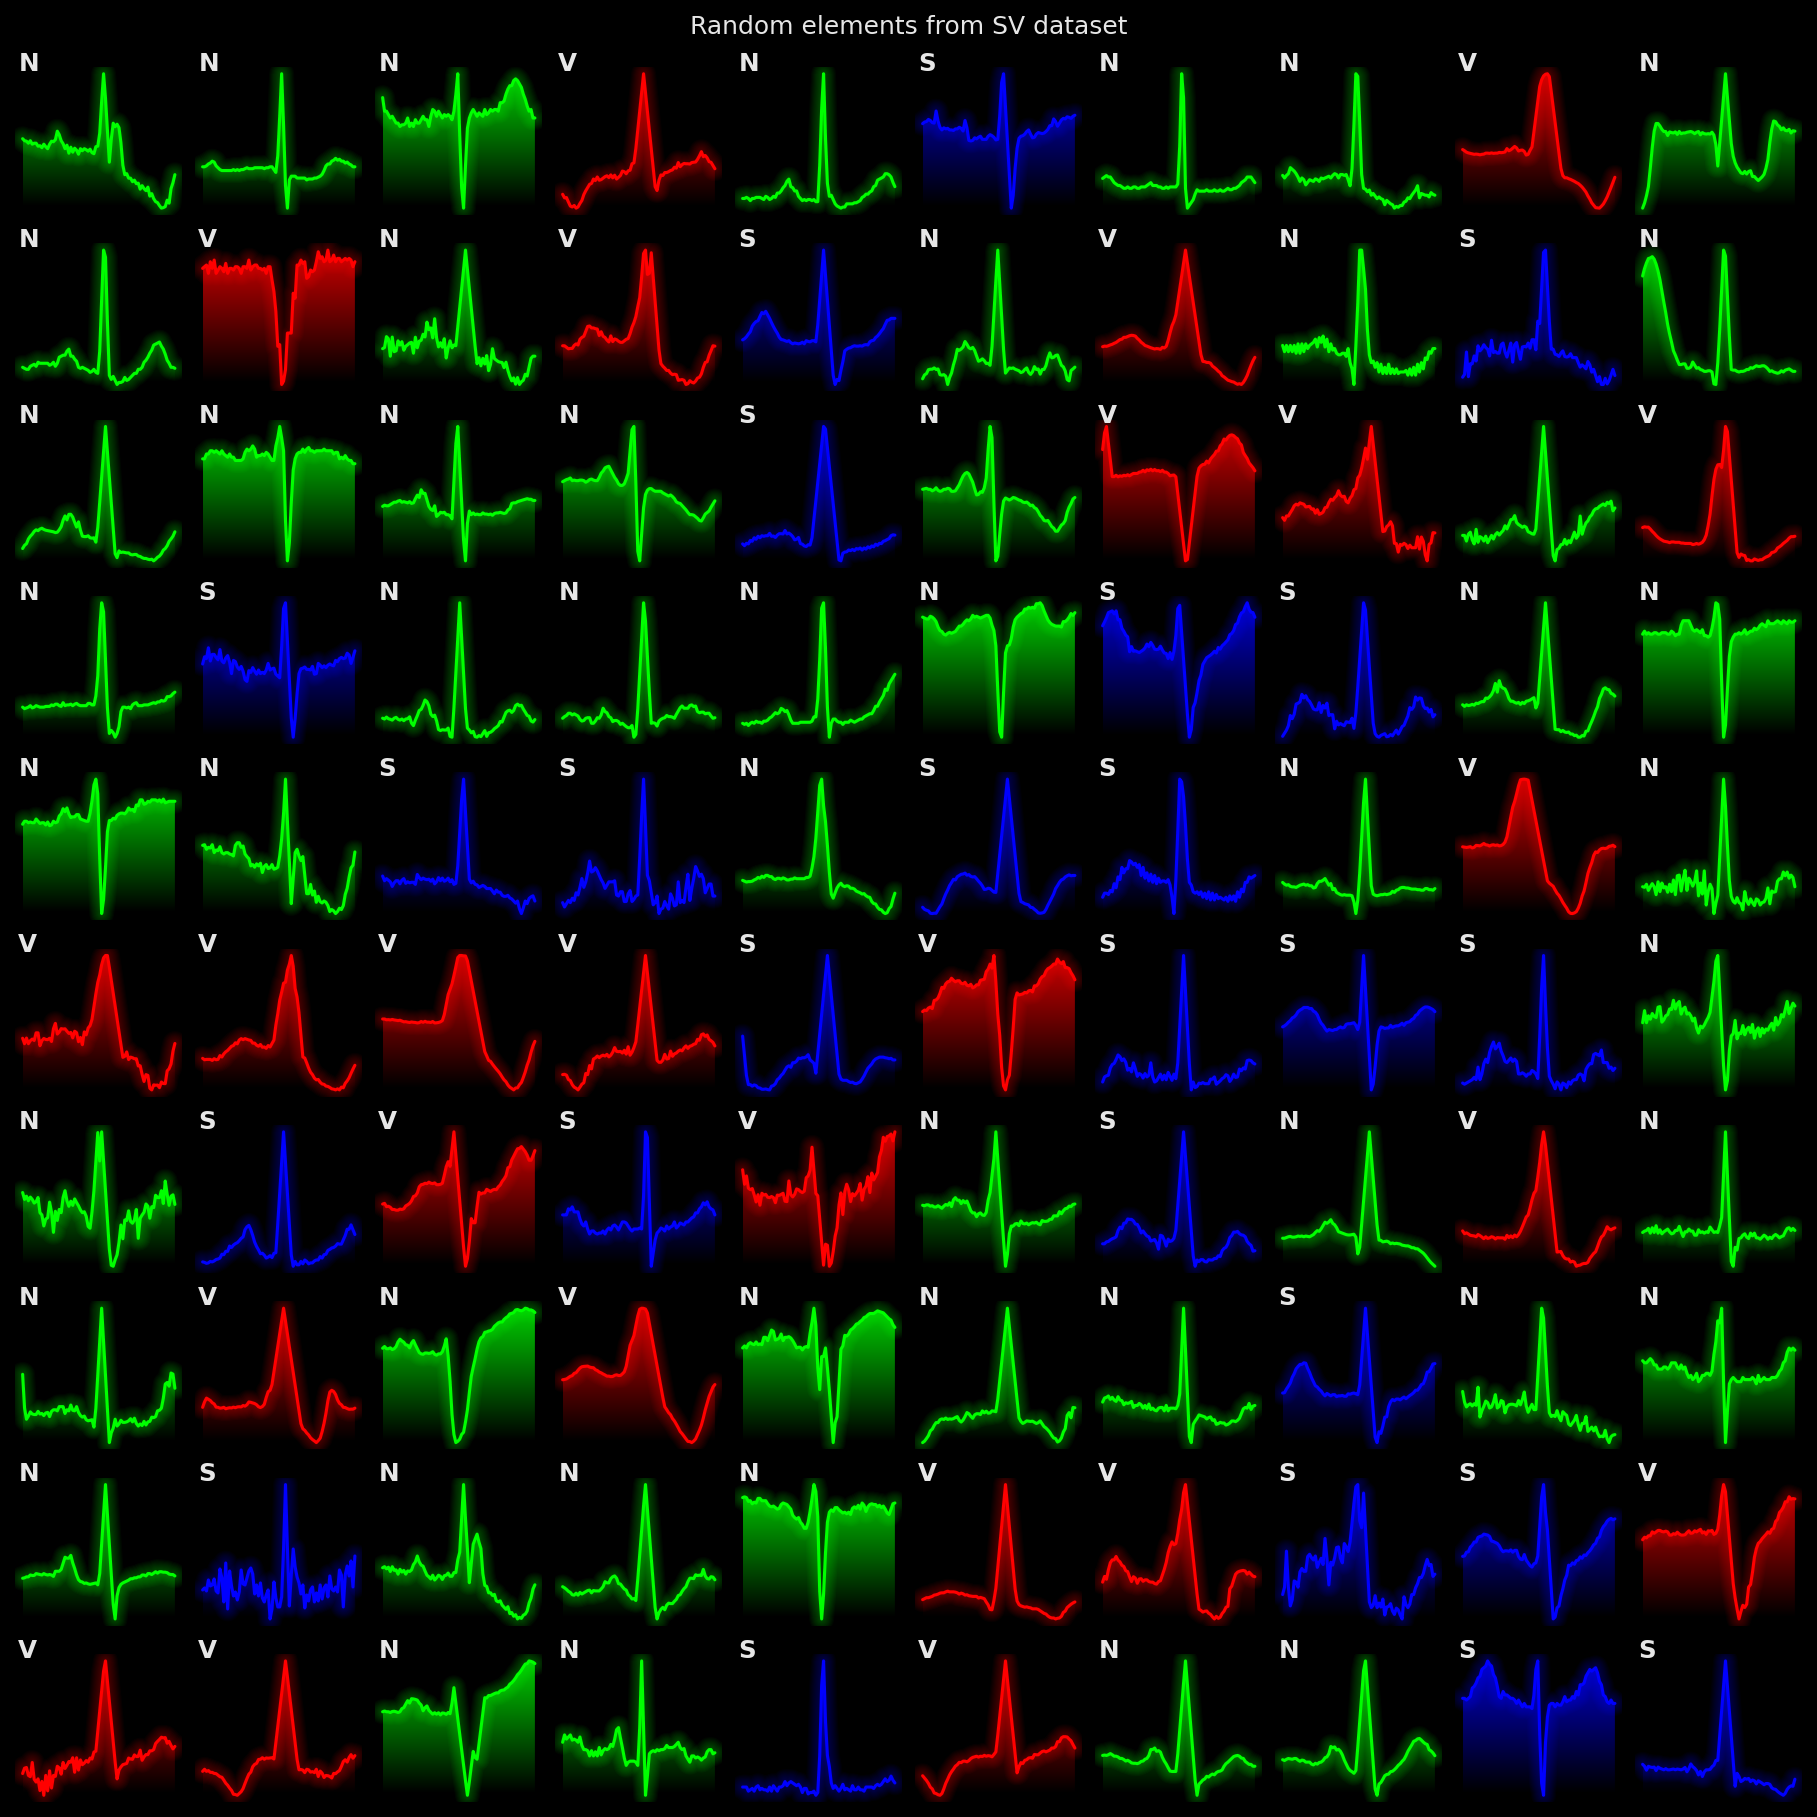

In [6]:
fig_title = 'Random elements from SV dataset'
props = {'N': 0.5, 'S': 0.25, 'V': 0.25}
plot_random_beats(all_beats, all_annotations, (10, 10), props, title=fig_title)

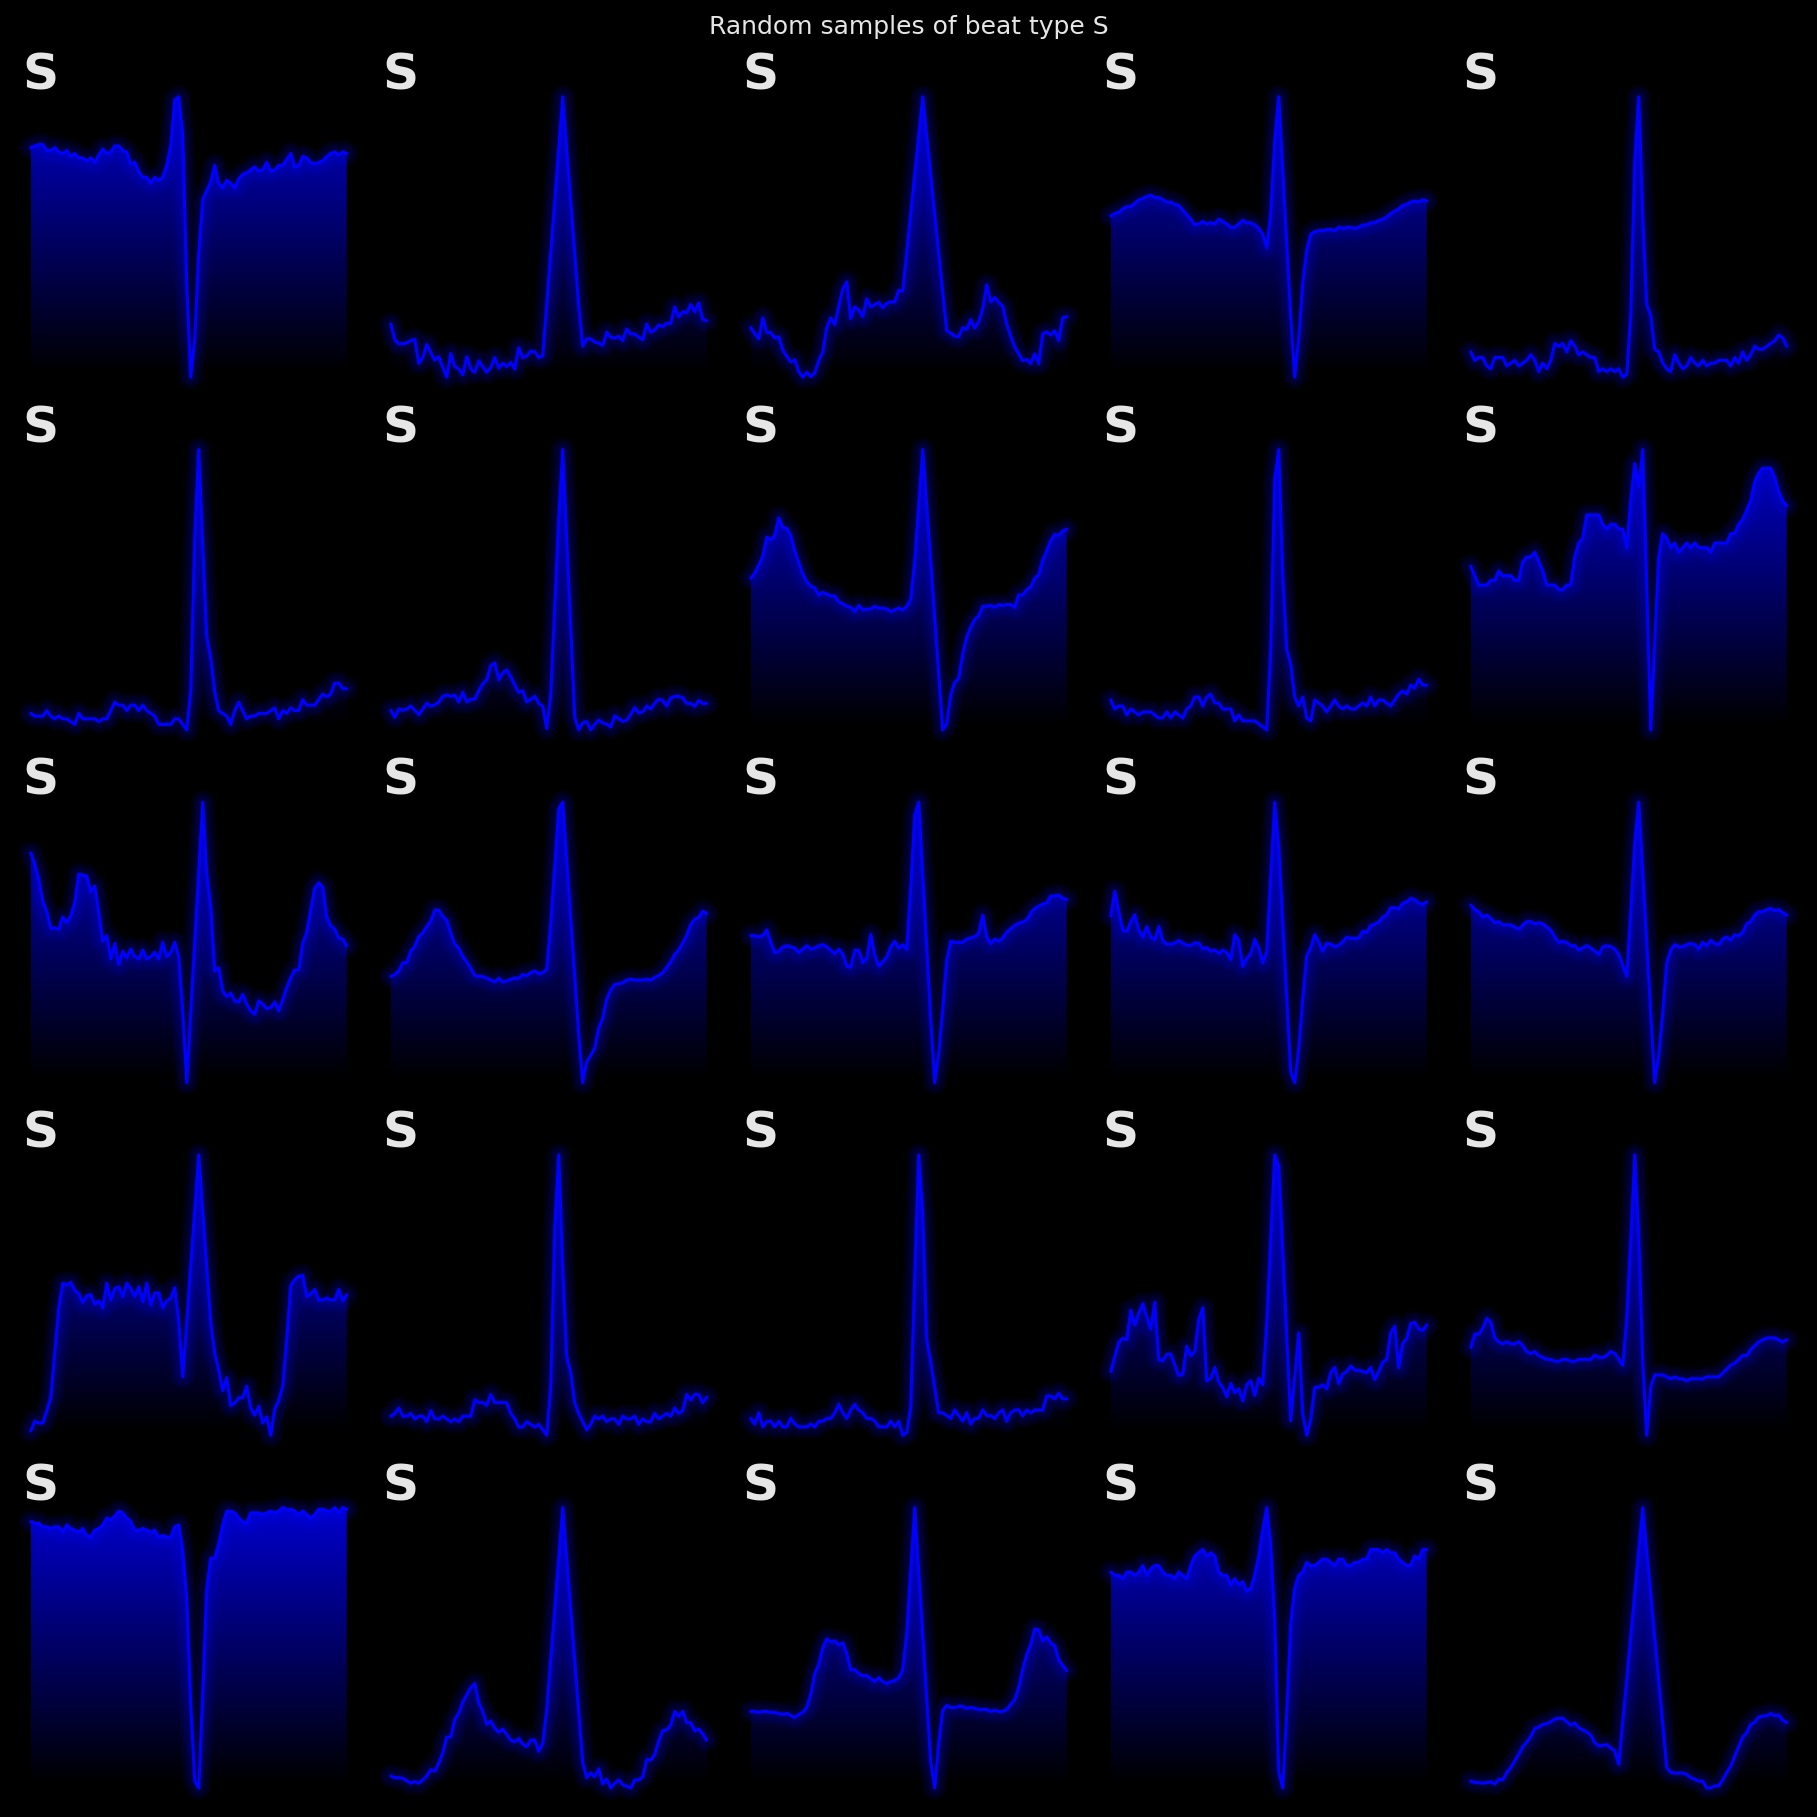

In [7]:
fig_title = 'Random samples of beat type S'
props = {'N': 0., 'S': 1., 'V': 0.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeS')

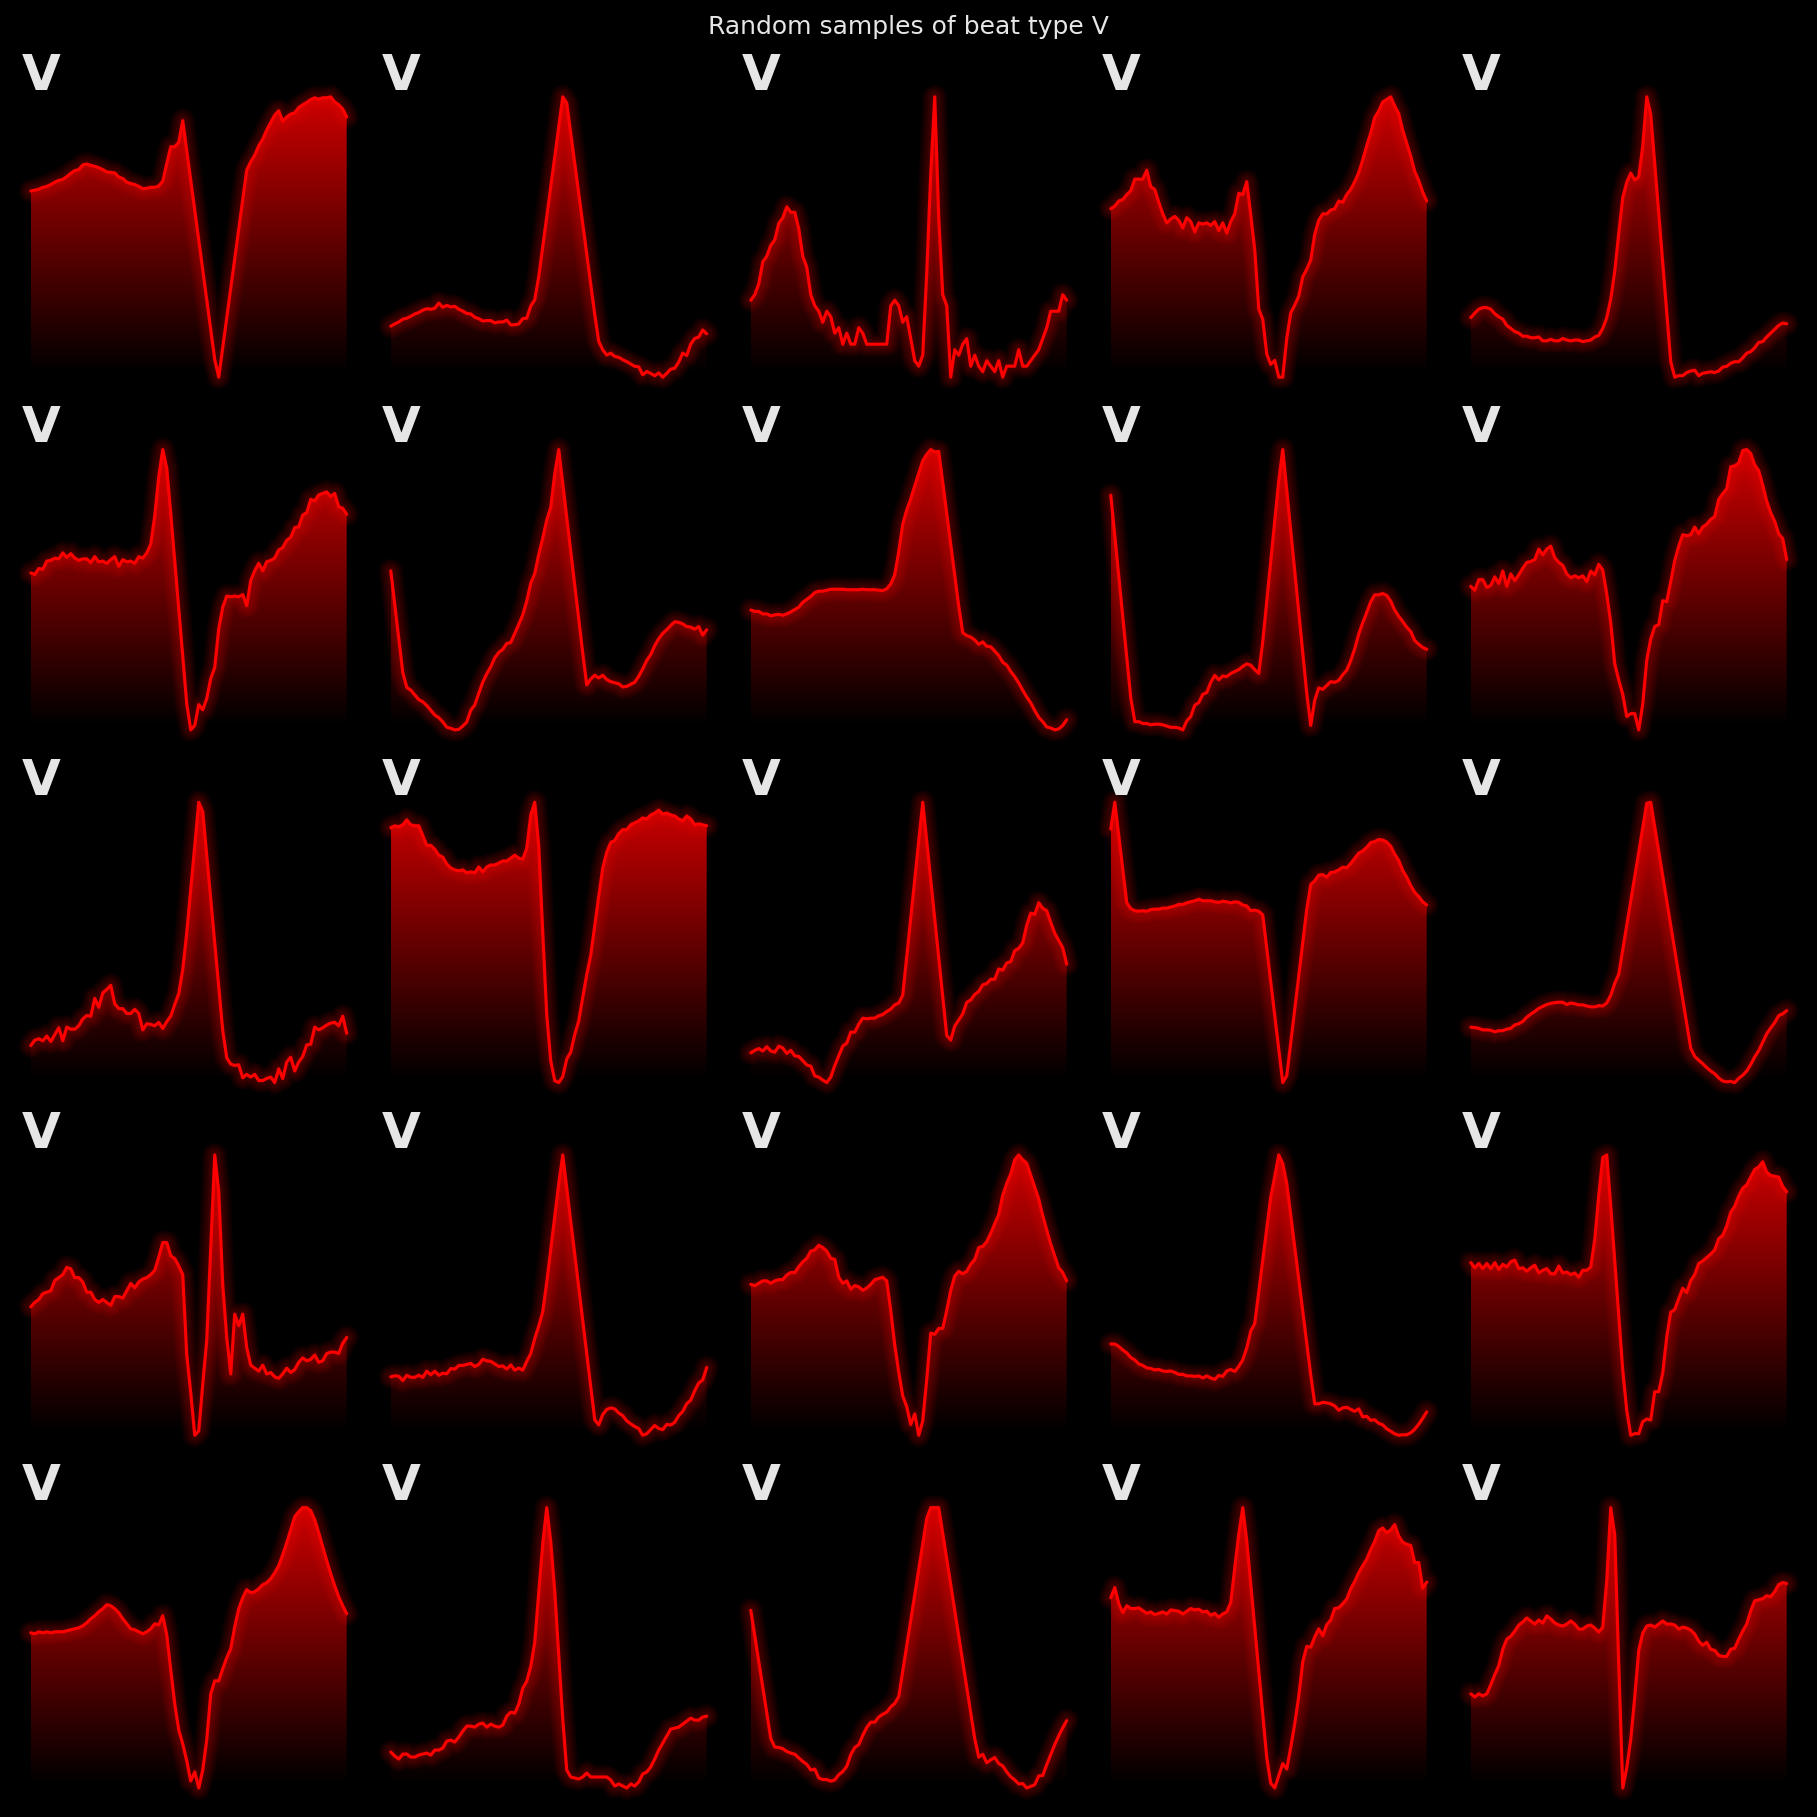

In [8]:
fig_title = 'Random samples of beat type V'
props = {'N': 0., 'S': 0., 'V': 1.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeV')

# Creating Custom Data-Loader object

### Encoding labels

In [9]:
annotations_encoder = LabelEncoder()
annotations_encoded = annotations_encoder.fit_transform(all_annotations)
print(annotations_encoder.classes_)
print(annotations_encoded[:10])

['N' 'S' 'V']
[0 0 0 0 0 0 0 0 0 0]


In [10]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.9
    weight_decay: float = 0.005
    epochs: int = 10
    device: torch.device = torch.device('cpu')
    dropout: float = 0.3
    batch_norm: bool = True
params = LearningParameters()


def normalize_dataset(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)


class ECGDataset(Dataset):
    def __init__(self, waveforms, labels, transform=None):
        self.waveforms = torch.tensor(waveforms, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx]
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, self.labels[idx]
    

class ECGModel(nn.Module):
    def __init__(self, waveform_len, activation=nn.ReLU()):
        super(ECGModel, self).__init__()
        
        self.waveform_net = nn.Sequential(
            nn.Linear(waveform_len, 256),
            activation,
            nn.Linear(256, 128),
            activation,
            nn.Linear(128, 64),
            activation
        )
        self.combined_net = nn.Sequential(
            nn.Linear(64, 32),
            activation,
            nn.Linear(32, 3),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.combined_net(self.waveform_net(x))

In [11]:
def calculate_accuracy(y_pred, y_true, correct_beat_idx=0):
    acc_t = (y_pred == y_true).sum().item() / len(y_true)
    arrhythmia = (y_true != correct_beat_idx).sum().item()
    if arrhythmia == 0:
        return acc_t, None
    else:
        acc_a = torch.logical_and(
            y_pred == y_true, y_true != correct_beat_idx
        ).sum().item() / arrhythmia
        return acc_t, acc_a

def train_step(model, data_loader, loss_function, accuracy_function, optimizer, device):
    train_loss = 0
    acc_t, acc_a = 0, 0
    acc_a_correction = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        acc_t_loop, acc_a_loop = accuracy_function(y_pred.argmax(dim=1), y)
        acc_t += acc_t_loop
        if acc_a_loop is None:
            acc_a_correction += 1
        else:
            acc_a += acc_a_loop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= (data_len := len(data_loader))
    acc_t /= data_len
    acc_a /= (data_len - acc_a_correction)
    return train_loss, acc_t, acc_a

def test_step(model, data_loader, loss_function, accuracy_function, device):
    test_loss = 0
    acc_t, acc_a = 0, 0
    acc_a_correction = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_function(test_pred, y)
            test_loss += loss.item()
            acc_t_loop, acc_a_loop = accuracy_function(test_pred.argmax(dim=1), y)
            acc_t += acc_t_loop
            if acc_a_loop is None:
                acc_a_correction += 1
            else:
                acc_a += acc_a_loop
            
        test_loss /= (data_len := len(data_loader))
        acc_t /= data_len
        acc_a /= (data_len - acc_a_correction)
    return test_loss, acc_t, acc_a

def plot_loss_and_accuracy(title, epochs, losses, acc_ts, acc_as):
    data_parts = ['Train', 'Test']
    colors = ['lime', 'red']
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplot_mosaic(
            [['Loss', 'Loss'], ['Acct', 'Acca']],
            layout='constrained', figsize=(10, 8))
        x_data = range(1, epochs + 1)
        for loss, data_part, color in zip(losses, data_parts, colors):
            axes['Loss'].plot(x_data, loss, label=f'{data_part}: {loss[-1]:.3f}', color=color)
        axes['Loss'].set(ylabel='Loss', xlabel='epoch', title=title)
        for acc_t, data_part, color in zip(acc_ts, data_parts, colors):
            axes['Acct'].plot(x_data, acc_t, label=f'{data_part} Acc_t: {acc_t[-1]:.3f}%', color=color)
        axes['Acct'].set(ylabel='Acc_t', xlabel='epoch', title='Accuracy')
        for acc_a, data_part, color in zip(acc_as, data_parts, colors):
            axes['Acca'].plot(x_data, acc_a, label=f'{data_part} Acc_a: {acc_a[-1]:.3f}%', color=color)
        axes['Acca'].set(ylabel='Acc_a', xlabel='epoch', title='Arrhythmia accuracy')
        for ax in figure.axes:
            ax.legend()
            enhance_plot(figure, ax)
        return figure, axes

def append_metrics(metric_lists, metrics):
    for metric_list, metric in zip(metric_lists, metrics):
        metric_list.append(metric)

In [12]:
split = int(0.7 * len(all_annotations))
ecg_dataset_train = ECGDataset(all_beats[:split], annotations_encoded[:split])
ecg_dataset_test = ECGDataset(all_beats[split:], annotations_encoded[split:])

train_dataloader = DataLoader(ecg_dataset_train, batch_size=params.batch_size, shuffle=True)
test_dataloader = DataLoader(ecg_dataset_test, batch_size=params.batch_size, shuffle=False)
len(train_dataloader), len(test_dataloader), len(all_beats[0])

(1005, 431, 80)

In [13]:
model = ECGModel(len(all_beats[0]))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
model

ECGModel(
  (waveform_net): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (combined_net): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
    (3): Softmax(dim=1)
  )
)

In [14]:
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, params.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, params.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')

100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

Time: 41.079 seconds


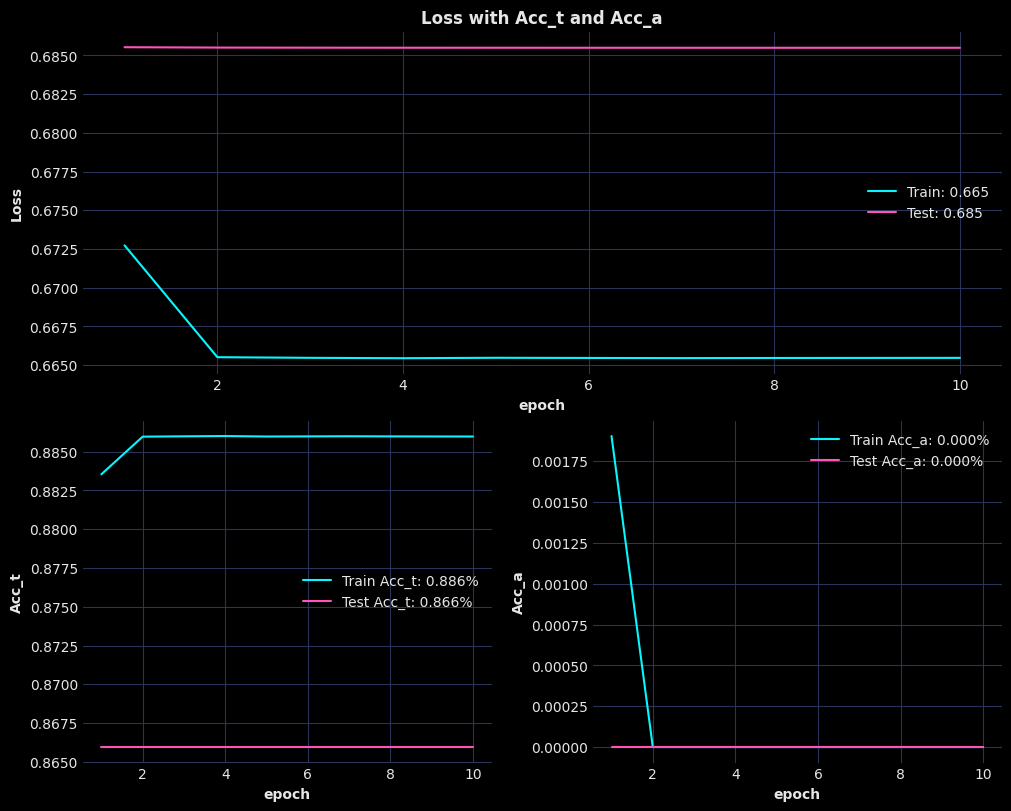

In [15]:
title = f'Loss with Acc_t and Acc_a'
plot_loss_and_accuracy(title, params.epochs, 
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

The number of N types is too large compared to others. Let's reduce it to 1/3

In [16]:
v_beats = np.count_nonzero(all_annotations == 'V')
picks = randomly_pick_indexes(all_annotations, 
                              3 * v_beats, 
                              {'N': 1/3, 'S': 1/3, 'V': 1/3})
reduced_beats = all_beats[picks]
reduced_annotations = all_annotations[picks]
print(f'Number of beat types "V": {v_beats}')
print(f'Reduced database length: {len(reduced_annotations)}')

reduced_annotations_encoded = annotations_encoder.transform(reduced_annotations)
print([(ann, idx) for idx, ann in 
       zip(reduced_annotations_encoded[:10], reduced_annotations[:10])])

Number of beat types "V": 9908
Reduced database length: 29724
[('S', 1), ('V', 2), ('V', 2), ('S', 1), ('N', 0), ('N', 0), ('N', 0), ('S', 1), ('N', 0), ('N', 0)]


In [17]:
params.batch_size = 16
params.epochs = 100
params.learning_rate = 0.05
params.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

split = int(0.7 * len(reduced_annotations))
ecg_dataset_train = ECGDataset(reduced_beats[:split], reduced_annotations_encoded[:split])
ecg_dataset_test = ECGDataset(reduced_beats[split:], reduced_annotations_encoded[split:])

train_dataloader = DataLoader(
    ecg_dataset_train, batch_size=params.batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(
    ecg_dataset_test, batch_size=params.batch_size, shuffle=False, pin_memory=True)
len(train_dataloader), len(test_dataloader), len(reduced_beats[0])

(1301, 558, 80)

100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


Time: 232.423 seconds


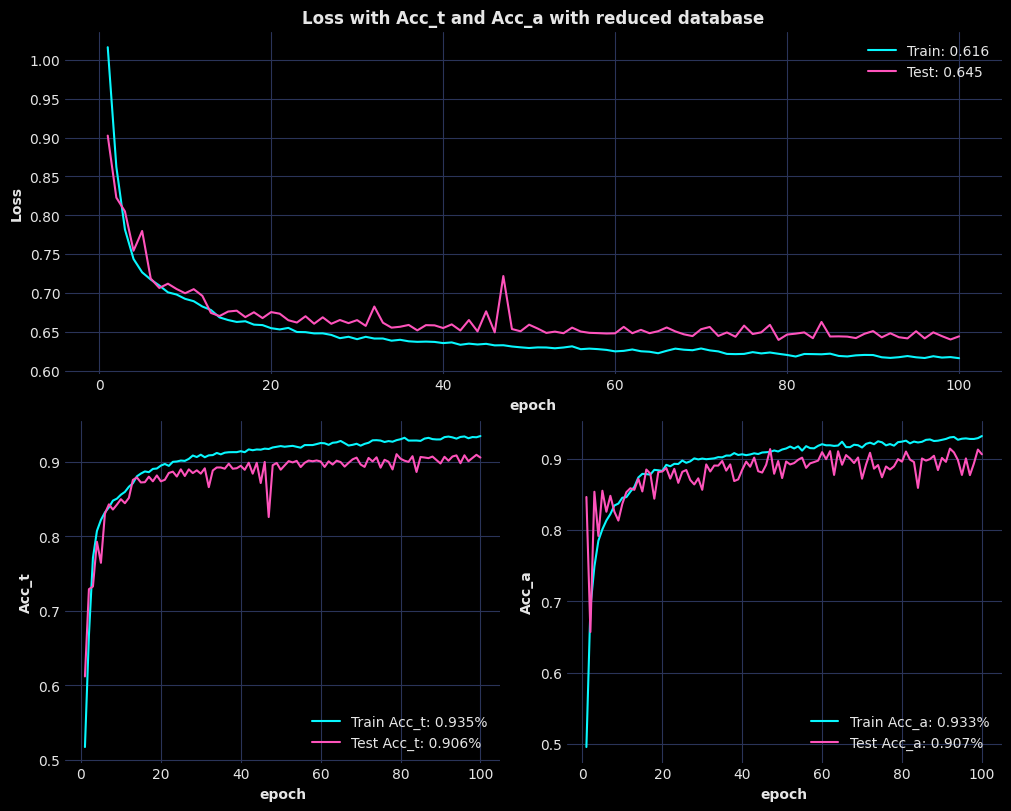

In [18]:
model = ECGModel(len(reduced_beats[0]))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=params.learning_rate)
                            # momentum=params.momentum,
                            # weight_decay=params.weight_decay)
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, params.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, params.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')
title = f'Loss with Acc_t and Acc_a with reduced database'
plot_loss_and_accuracy(title, params.epochs, 
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

Second model will be 1D CNN